# 04: Forecasting
### A grid-aware operational intelligence layer:

In [ ]:
# ============================
# CELL 0.5 — LOAD & INVENTORY ALL DATA
# ============================

import pandas as pd

# ----------------------------
# STAGE ARTEFACTS (already frozen)
# ----------------------------

stage1_results = pd.read_csv(
    "stage1_system_state_2025.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

stage2_model = pd.read_csv(
    "stage2_curtailment_model_2025.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

stage3_results = pd.read_csv(
    "stage3_offshore_simulation_results.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

# ----------------------------
# RAW / AUXILIARY DATASETS
# ----------------------------

# Meteorological mast data (10m height)
met_mast = pd.read_excel(
    "LDT_MET_MAST_10M.xlsx",
    parse_dates=["StartTime"]
)

# ----------------------------
# INVENTORY UTILITY
# ----------------------------
def inventory(name, df, time_col=None):

    print(f"\n===== {name} =====")
    print("Shape:", df.shape)
    print("Columns:")
    for c in df.columns:
        print(" ", c)

    if time_col and time_col in df.columns:
        tmin = df[time_col].min()
        tmax = df[time_col].max()
        print("Time range:", tmin, "→", tmax)

    elif isinstance(df.index, pd.DatetimeIndex):

        print("Time range:", df.index.min(), "→", df.index.max())
        print("Index dtype:", df.index.dtype)
        print("Monotonic:", df.index.is_monotonic_increasing)
        print("Duplicate timestamps:", df.index.duplicated().sum())

        if df.index.size > 1:
            dt = (
                df.index.to_series()
                .diff()
                .dt.total_seconds()
                .dropna()
                .median()
            )
            print("Median timestep (seconds):", dt)

    # Scenario awareness for Stage 3
    if "Scenario" in df.columns:
        print("Scenarios detected:", df["Scenario"].unique())

# Execute inventory for verification
stage2_model = stage2_model[~stage2_model.index.duplicated(keep="first")]
inventory("STAGE 2 — System + Curtailment", stage2_model)
inventory("STAGE 3 — Offshore Simulation", stage3_results)
inventory("MET MAST 10 m", met_mast, time_col="StartTime")
inventory("STAGE 1 — System State", stage1_results)
# Align Stage 1 to 30-minute resolution to match Stage 2
stage1_results = (
    stage1_results
    .resample("30T")
    .mean()
)


===== STAGE 2 — System + Curtailment =====
Shape: (17518, 21)
Columns:
  AI Demand
  AI Wind Availability
  AI Wind Generation
  AI Solar Generation
  SNSP
  SNSP_REGIME
  AI Oversupply
  Moyle I/C
  EWIC I/C
  Inter-Jurisdictional Flow
  Total IC Flow
  Hour
  DD_MWH
  CURTAILMENTS_MWH
  CONSTRAINTS_MWH
  OTHER_MWH
  TRANS_CONSTR_MWH
  HF_MIN_GEN_MWH
  SNSP_MWH
  ROCOF_INERTIA_MWH
  TSO_TEST_MWH
Time range: 2025-01-01 00:00:00+00:00 → 2025-12-31 23:30:00+00:00
Index dtype: datetime64[ns, UTC]
Monotonic: True
Duplicate timestamps: 0
Median timestep (seconds): 1800.0

===== STAGE 3 — Offshore Simulation =====
Shape: (52554, 12)
Columns:
  Scenario
  Offshore_MW
  Offshore_Accepted_MW
  Node_Waste_MW
  Offshore_Consumed_MW
  Offshore_Exported_MW
  Offshore_Curtailed_MW
  SNSP_BINDING
  AI Demand
  AI Wind Generation
  AI Solar Generation
  Total IC Flow
Time range: 2025-01-01 00:00:00+00:00 → 2025-12-31 23:30:00+00:00
Index dtype: datetime64[ns, UTC]
Monotonic: True
Duplicate timestamps

In [2]:
print(len(stage2_model))
print(stage2_model.index.duplicated().sum())
print(
    stage2_model.index.to_series().diff().dt.total_seconds().median()
)

print(
    stage1_results.index.to_series()
    .diff()
    .dt.total_seconds()
    .dropna()
    .median()
)

17518
0
1800.0
1800.0


In [ ]:
# ============================
# CELL 1 — COLUMN ROLE MAP
# ============================

COLUMN_ROLES = {}

COLUMN_ROLES.update({

    # Time / structure
    "Hour": "metadata",
    "Scenario": "metadata",

    # Offshore state (post Stage 3 physics)
    "Offshore_MW": "state",
    "Offshore_Accepted_MW": "state",
    "Node_Waste_MW": "state",
    "Offshore_Exported_MW": "state",
    "Offshore_Consumed_MW": "state",
    "Offshore_Curtailed_MW": "state",

    # Interconnectors / grid state
    "EWIC I/C": "state",
    "Moyle I/C": "state",
    "Inter-Jurisdictional Flow": "state",
    "Total IC Flow": "state",

    # SNSP / grid regime
    "SNSP": "state",
    "SNSP_MWH": "state",
    "SNSP_REGIME": "state",
    "SNSP_BINDING": "state",

    # Constraint accounting (targets)
    "CURTAILMENTS_MWH": "target",
    "CONSTRAINTS_MWH": "target",
    "TRANS_CONSTR_MWH": "target",
    "OTHER_MWH": "target",
    "DD_MWH": "target",
    "TSO_TEST_MWH": "target",
    "HF_MIN_GEN_MWH": "target",

    # AI-derived (exclude from decision layer)
    "AI Wind Generation": "excluded",
    "AI Wind Availability": "excluded",
    "AI Demand": "excluded",
    "AI Solar Generation": "excluded",
    "AI Oversupply": "excluded",

    "ROCOF_INERTIA_MWH": "state"
})


all_cols = set(stage1_results.columns) | set(stage2_model.columns) | set(stage3_results.columns)
unmapped = all_cols - set(COLUMN_ROLES.keys())
print("Unmapped columns:", unmapped)

all_cols = (
    set(stage1_results.columns) | 
    set(stage2_model.columns) | 
    set(stage3_results.columns)
)

unmapped = all_cols - set(COLUMN_ROLES.keys())

if len(unmapped) > 0:
    print(f"Warning: {len(unmapped)} unmapped columns found.")
    print("Unmapped columns:", unmapped)
else:
    print("Success: All columns mapped to roles.")


Unmapped columns: set()
Success: All columns mapped to roles.


In [4]:
# ============================
# CELL 2 — DECISION-STATE TABLE (PER SCENARIO)
# ============================

# Backbone: system state (no scenario stacking)
system_backbone = (
    stage1_results
        .join(stage2_model, how="inner", lsuffix="_s1", rsuffix="_s2")
)

feature_roles = ("state", "constraint")

allowed_cols = [
    c for c, r in COLUMN_ROLES.items()
    if r in feature_roles
]

scenario_decision_tables = {}

for scenario in stage3_results["Scenario"].unique():

    stage3_scenario = stage3_results[
        stage3_results["Scenario"] == scenario
    ]

    stage3_scenario = stage3_scenario.drop(
    columns=[
        c for c in stage3_scenario.columns
        if c in system_backbone.columns
    ],
    errors="ignore"
)

    merged = system_backbone.join(stage3_scenario, how="inner")


    available_cols = []
    for c in allowed_cols:
        if c in merged.columns:
            available_cols.append(c)
        elif f"{c}_s1" in merged.columns:
            available_cols.append(f"{c}_s1")
        elif f"{c}_s2" in merged.columns:
            available_cols.append(f"{c}_s2")

    decision_df = (
        merged[available_cols]
            .sort_index()
            .dropna()
    )

    scenario_decision_tables[scenario] = decision_df

    print(f"{scenario}: {decision_df.shape}")

print("Stage 4 decision tables built per scenario.")


Offshore_0p5GW: (17518, 15)
Offshore_1GW: (17518, 15)
Offshore_5GW: (17518, 15)
Stage 4 decision tables built per scenario.


In [ ]:
# ============================
# CELL 2.5 — DERIVED STATE FEATURES (Operational & Spatial Layers)
# ============================

# 1. Interconnector stress ratio
if "Moyle I/C" in decision_df.columns and "EWIC I/C" in decision_df.columns:

    decision_df["ic_stress_ratio"] = (
        decision_df["Moyle I/C"].abs() +
        decision_df["EWIC I/C"].abs()
    ) / 1000.0  # 1000 MW combined thermal limit

    print("Computed ic_stress_ratio using Moyle + EWIC thermal proxy.")

else:
    ic_col = next((c for c in decision_df.columns if "Total IC Flow" in c), None)
    if ic_col:
        IC_CAPACITY_MW = decision_df[ic_col].abs().quantile(0.99)
        decision_df["ic_stress_ratio"] = (
            decision_df[ic_col].abs() / IC_CAPACITY_MW
        )
        print(f"Computed ic_stress_ratio using 99th percentile of {ic_col}")


# 2. SNSP binding flag
if "SNSP_BINDING" in decision_df.columns:
    decision_df["snsp_binding_flag"] = (
        decision_df["SNSP_BINDING"].astype(int)
    )
    print("Computed snsp_binding_flag.")


# 3. Low inertia flag
if "ROCOF_INERTIA_MWH" in decision_df.columns:

    threshold = decision_df["ROCOF_INERTIA_MWH"].quantile(0.1)
    decision_df["low_inertia_flag"] = (
        decision_df["ROCOF_INERTIA_MWH"] < threshold
    ).astype(int)

    print("Computed low_inertia_flag.")


# 4. Transmission congestion intensity (physics layer)
if "Node_Waste_MW" in decision_df.columns:

    decision_df["congestion_intensity"] = (
        decision_df["Node_Waste_MW"] /
        decision_df["Offshore_MW"].replace(0, 1)
    )

    print("Computed congestion_intensity.")

# Feature list for Stage 4
X_spatial_features = [
    "ic_stress_ratio",
    "snsp_binding_flag",
    "low_inertia_flag",
    "congestion_intensity"
]

print(f"Derived decision-state shape: {decision_df.shape}")
display(decision_df[X_spatial_features].head())


Computed ic_stress_ratio using 99th percentile of Total IC Flow
Computed snsp_binding_flag.
Computed low_inertia_flag.
Computed congestion_intensity.
Derived decision-state shape: (17518, 19)


,ic_stress_ratio,snsp_binding_flag,low_inertia_flag,congestion_intensity
DateTime,,,,
2025-01-01 00:00:00+00:00,0.698582,1,0,0.567283
2025-01-01 00:30:00+00:00,0.408959,1,0,0.542478
2025-01-01 01:00:00+00:00,0.499568,1,0,0.574104
2025-01-01 01:30:00+00:00,0.470082,1,0,0.566325
2025-01-01 02:00:00+00:00,0.494345,1,0,0.589548


In [6]:
# ============================
# CELL 3 — FORECAST HORIZONS (30-MIN RESOLUTION, PER SCENARIO)
# ============================

import numpy as np

# 30-minute resolution
STEPS_PER_HOUR = 2
HORIZONS_HOURS = [4, 12, 24]

STAGE3_TARGETS = ["Offshore_MW", "Offshore_Curtailed_MW"]
STAGE2_TARGETS = ["CURTAILMENTS_MWH", "Total IC Flow"]

datasets = {}

for scenario, X_s in scenario_decision_tables.items():

    s2_clean = stage2_model.copy()
    s3_clean = stage3_results[
        stage3_results["Scenario"] == scenario
    ].copy()

    scenario_datasets = {}

    for h in HORIZONS_HOURS:

        shift_steps = h * STEPS_PER_HOUR

        y_stage3 = (
            s3_clean[STAGE3_TARGETS]
            .shift(-shift_steps)
            .rename(columns={c: f"{c}_t+{h}h" for c in STAGE3_TARGETS})
        )

        y_stage2 = (
            s2_clean[STAGE2_TARGETS]
            .shift(-shift_steps)
            .rename(columns={c: f"{c}_t+{h}h" for c in STAGE2_TARGETS})
        )

        y = y_stage3.join(y_stage2, how="inner")

        df_h = X_s.join(y, how="inner").dropna()

        scenario_datasets[h] = df_h

        print(f"{scenario} — Horizon {h}h: {len(df_h):,} rows")

    datasets[scenario] = scenario_datasets

print("\nForecast datasets built per scenario at 30-minute resolution.")


Offshore_0p5GW — Horizon 4h: 17,510 rows
Offshore_0p5GW — Horizon 12h: 17,494 rows
Offshore_0p5GW — Horizon 24h: 17,470 rows
Offshore_1GW — Horizon 4h: 17,510 rows
Offshore_1GW — Horizon 12h: 17,494 rows
Offshore_1GW — Horizon 24h: 17,470 rows
Offshore_5GW — Horizon 4h: 17,510 rows
Offshore_5GW — Horizon 12h: 17,494 rows
Offshore_5GW — Horizon 24h: 17,470 rows

Forecast datasets built per scenario at 30-minute resolution.


In [7]:
# ============================
# CELL 3.5 — FINAL SANITY CHECK (PER SCENARIO)
# ============================

cleaned_datasets = {}

for scenario, horizon_dict in datasets.items():

    cleaned_datasets[scenario] = {}

    for h, df in horizon_dict.items():

        df_clean = df.dropna().copy()

        cleaned_datasets[scenario][h] = df_clean

        print(f"{scenario} — H{h}: {len(df_clean):,} rows")

datasets = cleaned_datasets


Offshore_0p5GW — H4: 17,510 rows
Offshore_0p5GW — H12: 17,494 rows
Offshore_0p5GW — H24: 17,470 rows
Offshore_1GW — H4: 17,510 rows
Offshore_1GW — H12: 17,494 rows
Offshore_1GW — H24: 17,470 rows
Offshore_5GW — H4: 17,510 rows
Offshore_5GW — H12: 17,494 rows
Offshore_5GW — H24: 17,470 rows


In [ ]:
# ============================
# CELL 4 — BASELINE FORECASTS (PER SCENARIO)
# ============================

import numpy as np

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat) ** 2))

def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

BASELINE_RESULTS = {}

for scenario, horizon_dict in datasets.items():

    BASELINE_RESULTS[scenario] = {}

    for h, df in horizon_dict.items():

        target_offshore_col = f"Offshore_MW_t+{h}h"
        target_curt_col = f"CURTAILMENTS_MWH_t+{h}h"
        
        current_cols = [
            c for c in df.columns
            if c == "Offshore_MW"
        ]

        if not current_cols:
            print(f"{scenario} H{h}: Offshore_MW not found.")
            continue

        current_val_col = current_cols[0]

        eval_df = df[
            [current_val_col, target_offshore_col, target_curt_col]
        ].dropna()

        y_now = eval_df[current_val_col]
        y_future = eval_df[target_offshore_col]
        y_curt_future = eval_df[target_curt_col]

        # Offshore persistence baseline
        p_rmse = rmse(y_future, y_now)
        p_mae = mae(y_future, y_now)

        # Curtailment zero baseline
        z_rmse = rmse(y_curt_future, np.zeros(len(y_curt_future)))
        z_mae = mae(y_curt_future, np.zeros(len(y_curt_future)))

        BASELINE_RESULTS[scenario][h] = {
            "offshore_persistence_rmse": p_rmse,
            "offshore_persistence_mae": p_mae,
            "curtailment_zero_rmse": z_rmse,
            "curtailment_zero_mae": z_mae
        }

        print(f"\n{scenario} — H{h}")
        print(f"Offshore Persistence RMSE: {p_rmse:,.2f}")
        print(f"Offshore Persistence MAE:  {p_mae:,.2f}")
        print(f"Curtailment Zero RMSE:     {z_rmse:,.2f}")
        print(f"Curtailment Zero MAE:      {z_mae:,.2f}")



Offshore_0p5GW — H4
Offshore Persistence RMSE: 146.28
Offshore Persistence MAE:  114.22
Curtailment Zero RMSE:     53.38
Curtailment Zero MAE:      11.38

Offshore_0p5GW — H12
Offshore Persistence RMSE: 173.37
Offshore Persistence MAE:  138.88
Curtailment Zero RMSE:     53.34
Curtailment Zero MAE:      11.36

Offshore_0p5GW — H24
Offshore Persistence RMSE: 178.74
Offshore Persistence MAE:  143.07
Curtailment Zero RMSE:     53.37
Curtailment Zero MAE:      11.38

Offshore_1GW — H4
Offshore Persistence RMSE: 292.55
Offshore Persistence MAE:  228.43
Curtailment Zero RMSE:     53.38
Curtailment Zero MAE:      11.38

Offshore_1GW — H12
Offshore Persistence RMSE: 346.73
Offshore Persistence MAE:  277.76
Curtailment Zero RMSE:     53.34
Curtailment Zero MAE:      11.36

Offshore_1GW — H24
Offshore Persistence RMSE: 357.48
Offshore Persistence MAE:  286.14
Curtailment Zero RMSE:     53.37
Curtailment Zero MAE:      11.38

Offshore_5GW — H4
Offshore Persistence RMSE: 1,462.75
Offshore Persiste

In [ ]:
# ============================
# CELL 5A — OFFSHORE POWER ML (ENCODED)
# ============================

import joblib
import os
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

# Create a folder for your models if it doesn't exist
os.makedirs('models', exist_ok=True)

def split_and_encode(df, target_col, split_frac=0.7):
    """
    Standardized split & encode that returns 7 values for the Simulator.
    """
    # 1. Define Features (X) and Target (y)
    future_cols = [c for c in df.columns if "t+" in c]
    X = df.drop(columns=future_cols)
    y = df[target_col]

    # 2. Identify categorical vs numeric
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

    # 3. Time-based split
    split_idx = int(len(df) * split_frac)
    X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # 4. One-Hot Encoding
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    if len(cat_cols) > 0:
        ohe.fit(X_train_raw[cat_cols])
        
        def transform(raw_df):
            X_cat = ohe.transform(raw_df[cat_cols])
            X_num = raw_df[num_cols].values
            return np.hstack([X_num, X_cat])
        
        X_train_enc = transform(X_train_raw)
        X_test_enc = transform(X_test_raw)
    else:
        X_train_enc = X_train_raw.values
        X_test_enc = X_test_raw.values

    return X_train_enc, X_test_enc, y_train, y_test, num_cols, cat_cols, ohe

# ----------------------------
# TRAINING LOOP (PER SCENARIO)
# ----------------------------

ML_RESULTS = {}
MODEL_BUNDLES = {}

for scenario, horizon_dict in datasets.items():
    ML_RESULTS[scenario] = {}
    MODEL_BUNDLES[scenario] = {}

    for h, df in horizon_dict.items():
        target = f"Offshore_MW_t+{h}h"

        # Extract features and encoder
        X_train, X_test, y_train, y_test, num_c, cat_c, encoder = split_and_encode(
            df, target_col=target
        )

        model = GradientBoostingRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1,
            random_state=42
        )

        model.fit(X_train, y_train)
        rmse_val = mean_squared_error(y_test, model.predict(X_test), squared=False)
        ML_RESULTS[scenario][h] = {"rmse": rmse_val}

        MODEL_BUNDLES[scenario][h] = {
            "model": model,
            "encoder": encoder,
            "num_cols": num_c,   
            "cat_cols": cat_c    
        }

        print(f"{scenario} — H{h} | RMSE: {rmse_val:,.2f}")

# Save the bundle
joblib.dump(MODEL_BUNDLES, 'models/full_balancing_bundle.pkl')
print("\n[SUCCESS] Offshore models saved with feature-alignment metadata.")

Offshore_0p5GW — H4 | RMSE: 125.38
Offshore_0p5GW — H12 | RMSE: 139.24
Offshore_0p5GW — H24 | RMSE: 142.69
Offshore_1GW — H4 | RMSE: 251.23
Offshore_1GW — H12 | RMSE: 280.01
Offshore_1GW — H24 | RMSE: 287.30
Offshore_5GW — H4 | RMSE: 1,255.06
Offshore_5GW — H12 | RMSE: 1,388.10
Offshore_5GW — H24 | RMSE: 1,426.79

[SUCCESS] Offshore models saved with feature-alignment metadata.


In [ ]:
# ============================
# CELL 5B — CURTAILMENT RISK (LEAK-FREE, TIME-SAFE)
# ============================

import numpy as np
import pandas as pd
import joblib
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

os.makedirs('models', exist_ok=True)

RISK_RESULTS = {}
RISK_MODELS = {}

FORBIDDEN_KEYWORDS = [
    "CURTAIL", "CONSTR", "SNSP", "IC", "FLOW", "EXPORT", "RATIO", 
    "STRESS", "HEADROOM", "SURPLUS", "LIMIT", "CAP", "BIND", 
    "CONGEST", "MARGIN", "BALANCE", "OVERFLOW", "NET"
]

for scenario, horizon_dict in datasets.items():

    RISK_RESULTS[scenario] = {}
    RISK_MODELS[scenario] = {}

    for h, df in horizon_dict.items():

        df = df.copy()

        target = f"CURTAILMENTS_MWH_t+{h}h"
        y_event = (df[target] > 0).astype(int)

        # ---------------------------------------------------
        # Remove all future columns
        # ---------------------------------------------------
        cols_to_drop = [c for c in df.columns if "_t+" in c]

        # ---------------------------------------------------
        # Remove deterministic / post-dispatch features
        # ---------------------------------------------------
        for c in df.columns:
            if any(k in c.upper() for k in FORBIDDEN_KEYWORDS):
                cols_to_drop.append(c)

        X = df.drop(columns=list(set(cols_to_drop)), errors="ignore")

        # Keep only numeric features
        X = X.select_dtypes(include=[np.number])

        # ---------------------------------------------------
        # Chronological split (NO SHUFFLE)
        # ---------------------------------------------------
        split_idx = int(len(X) * 0.8)

        X_train = X.iloc[:split_idx]
        X_test  = X.iloc[split_idx:]

        y_train = y_event.iloc[:split_idx]
        y_test  = y_event.iloc[split_idx:]

        # ---------------------------------------------------
        # Logistic model
        # ---------------------------------------------------
        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("logit", LogisticRegression(
                max_iter=2000,
                class_weight="balanced",
                solver="lbfgs"
            ))
        ])

        clf.fit(X_train, y_train)

        # Evaluation
        yhat_prob = clf.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, yhat_prob)
        ap  = average_precision_score(y_test, yhat_prob)

        RISK_RESULTS[scenario][h] = {
            "roc_auc": roc,
            "avg_precision": ap
        }

        RISK_MODELS[scenario][h] = {
            "model": clf,
            "features": X_train.columns.tolist()
        }

        print(f"{scenario} — H{h} | ROC-AUC: {roc:.3f}")

# ----------------------------
# FINAL EXPORT
# ----------------------------
joblib.dump(RISK_MODELS, 'models/curtailment_risk_bundle.pkl')
print("\n[SUCCESS] Risk models and feature lists saved to 'models/curtailment_risk_bundle.pkl'")

Offshore_0p5GW — H4 | ROC-AUC: 0.637
Offshore_0p5GW — H12 | ROC-AUC: 0.555
Offshore_0p5GW — H24 | ROC-AUC: 0.560
Offshore_1GW — H4 | ROC-AUC: 0.652
Offshore_1GW — H12 | ROC-AUC: 0.567
Offshore_1GW — H24 | ROC-AUC: 0.578
Offshore_5GW — H4 | ROC-AUC: 0.700
Offshore_5GW — H12 | ROC-AUC: 0.654
Offshore_5GW — H24 | ROC-AUC: 0.569

[SUCCESS] Risk models and feature lists saved to 'models/curtailment_risk_bundle.pkl'


In [ ]:
# ============================
# CELL 6A — CURTAILMENT MAGNITUDE (LEAK-FREE, TIME-SAFE)
# ============================

import numpy as np
import pandas as pd
import joblib
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

os.makedirs('models', exist_ok=True)

MAG_RESULTS = {}
MAG_MODELS = {}

FORBIDDEN_KEYWORDS = [
    "CURTAIL", "CONSTR", "SNSP", "IC", "FLOW", "EXPORT", "RATIO",
    "STRESS", "HEADROOM", "SURPLUS", "LIMIT", "CAP", "BIND",
    "CONGEST", "MARGIN", "BALANCE", "OVERFLOW", "NET"
]

for scenario, horizon_dict in datasets.items():

    MAG_RESULTS[scenario] = {}
    MAG_MODELS[scenario] = {}

    for h, df in horizon_dict.items():

        df = df.copy()
        target = f"CURTAILMENTS_MWH_t+{h}h"

        # ------------------------------
        # Conditional model: events only
        # ------------------------------
        df_evt = df[df[target] > 0].copy()

        if len(df_evt) < 500:
            print(f"\n{scenario} H{h} — Skipped ({len(df_evt)} events)")
            continue

        # ------------------------------
        # Remove future + deterministic features
        # ------------------------------
        cols_to_drop = [c for c in df_evt.columns if "_t+" in c]

        for c in df_evt.columns:
            if any(k in c.upper() for k in FORBIDDEN_KEYWORDS):
                cols_to_drop.append(c)

        X = df_evt.drop(columns=list(set(cols_to_drop)), errors="ignore")
        X = X.select_dtypes(include=[np.number])

        y = df_evt[target]

        # ------------------------------
        # Chronological split
        # ------------------------------
        split_idx = int(len(X) * 0.8)

        X_train = X.iloc[:split_idx]
        X_test  = X.iloc[split_idx:]

        y_train = y.iloc[:split_idx]
        y_test  = y.iloc[split_idx:]

        # ------------------------------
        # Model
        # ------------------------------
        reg = GradientBoostingRegressor(
            loss="quantile",
            alpha=0.5,
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            random_state=42
        )

        reg.fit(X_train, y_train)
        yhat = reg.predict(X_test)

        rmse_val = mean_squared_error(y_test, yhat, squared=False)
        mae_val  = mean_absolute_error(y_test, yhat)
        norm_rmse = rmse_val / y_test.mean()

        MAG_RESULTS[scenario][h] = {
            "rmse": rmse_val,
            "mae": mae_val,
            "norm_rmse": norm_rmse,
            "n_events": len(df_evt)
        }
        
        MAG_MODELS[scenario][h] = {
            "model": reg,
            "features": X_train.columns.tolist()
        }

        print(f"{scenario} — H{h} MAGNITUDE | RMSE: {rmse_val:,.1f} MWh | Events: {len(df_evt)}")

# ----------------------------
# FINAL EXPORT
# ----------------------------
joblib.dump(MAG_MODELS, 'models/curtailment_magnitude_bundle.pkl')
print("\n[SUCCESS] Magnitude models and feature lists saved to 'models/curtailment_magnitude_bundle.pkl'")

Offshore_0p5GW — H4 MAGNITUDE | RMSE: 128.7 MWh | Events: 3197
Offshore_0p5GW — H12 MAGNITUDE | RMSE: 128.5 MWh | Events: 3195
Offshore_0p5GW — H24 MAGNITUDE | RMSE: 128.2 MWh | Events: 3195
Offshore_1GW — H4 MAGNITUDE | RMSE: 128.8 MWh | Events: 3197
Offshore_1GW — H12 MAGNITUDE | RMSE: 128.8 MWh | Events: 3195
Offshore_1GW — H24 MAGNITUDE | RMSE: 127.8 MWh | Events: 3195
Offshore_5GW — H4 MAGNITUDE | RMSE: 128.3 MWh | Events: 3197
Offshore_5GW — H12 MAGNITUDE | RMSE: 128.7 MWh | Events: 3195
Offshore_5GW — H24 MAGNITUDE | RMSE: 127.9 MWh | Events: 3195

[SUCCESS] Magnitude models and feature lists saved to 'models/curtailment_magnitude_bundle.pkl'


In [12]:
baseline = np.full_like(y_test, y_train.mean())
baseline_rmse = mean_squared_error(y_test, baseline, squared=False)
print("Baseline RMSE:", baseline_rmse)


Baseline RMSE: 113.80445554417842


In [ ]:
# ============================
# CELL 6B — IC FLOW FORECAST (TIME-SAFE)
# ============================

import numpy as np
import pandas as pd
import joblib
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

os.makedirs('models', exist_ok=True)

COMMITMENT_HORIZONS = [24, 4]

IC_FLOW_RESULTS = {}
IC_FLOW_MODELS = {}

FORBIDDEN_KEYWORDS = [
    "CURTAIL", "CONSTR", "SNSP", "BIND", "HEADROOM"
]

for scenario, horizon_dict in datasets.items():

    IC_FLOW_RESULTS[scenario] = {}
    IC_FLOW_MODELS[scenario] = {}

    for h in COMMITMENT_HORIZONS:

        if h not in horizon_dict:
            continue

        df = horizon_dict[h].copy()
        target_col = f"Total IC Flow_t+{h}h"

        if target_col not in df.columns:
            continue

        # --------------------------------
        # Remove future columns
        # --------------------------------
        future_cols = [c for c in df.columns if "_t+" in c]
        cols_to_drop = future_cols.copy()

        # --------------------------------
        # Remove deterministic leakage
        # --------------------------------
        for c in df.columns:
            if any(k in c.upper() for k in FORBIDDEN_KEYWORDS):
                cols_to_drop.append(c)

        X = df.drop(columns=list(set(cols_to_drop)), errors="ignore")
        X = X.select_dtypes(include=[np.number])

        y = df[target_col]

        # --------------------------------
        # Chronological split
        # --------------------------------
        split_idx = int(len(df) * 0.8)

        X_train = X.iloc[:split_idx]
        X_test  = X.iloc[split_idx:]

        y_train = y.iloc[:split_idx]
        y_test  = y.iloc[split_idx:]

        # --------------------------------
        # Model
        # --------------------------------
        model = GradientBoostingRegressor(
            n_estimators=300,
            max_depth=3,
            learning_rate=0.05,
            random_state=42
        )

        model.fit(X_train, y_train)
        yhat = model.predict(X_test)

        rmse_val = mean_squared_error(y_test, yhat, squared=False)

        IC_FLOW_RESULTS[scenario][h] = {
            "rmse": rmse_val
        }

        # SAVE MODEL + FEATURE LIST
        # Storing the exact column order is vital for GradientBoosting
        IC_FLOW_MODELS[scenario][h] = {
            "model": model,
            "features": X_train.columns.tolist()
        }

        print(f"{scenario} — H{h} IC Flow | RMSE: {rmse_val:,.1f} MW")

# ----------------------------
# FINAL EXPORT
# ----------------------------
joblib.dump(IC_FLOW_MODELS, 'models/ic_flow_bundle.pkl')
print("\n[SUCCESS] IC Flow models and feature lists saved to 'models/ic_flow_bundle.pkl'")

Offshore_0p5GW — H24 IC Flow | RMSE: 444.6 MW
Offshore_0p5GW — H4 IC Flow | RMSE: 318.0 MW
Offshore_1GW — H24 IC Flow | RMSE: 445.7 MW
Offshore_1GW — H4 IC Flow | RMSE: 317.7 MW
Offshore_5GW — H24 IC Flow | RMSE: 447.3 MW
Offshore_5GW — H4 IC Flow | RMSE: 315.2 MW

[SUCCESS] IC Flow models and feature lists saved to 'models/ic_flow_bundle.pkl'


In [ ]:
# ============================
# CELL 6C — IC SATURATION RISK (TIME-SAFE)
# ============================

import numpy as np
import pandas as pd
import joblib
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

os.makedirs('models', exist_ok=True)

COMMITMENT_HORIZONS = [24, 4]

IC_SAT_RESULTS = {}
IC_SAT_MODELS = {}

for scenario, horizon_dict in datasets.items():

    IC_SAT_RESULTS[scenario] = {}
    IC_SAT_MODELS[scenario] = {}

    for h in COMMITMENT_HORIZONS:

        if h not in horizon_dict:
            continue

        df = horizon_dict[h].copy()

        target_flow_col = f"Total IC Flow_t+{h}h"
        if target_flow_col not in df.columns:
            continue

        # --------------------------------
        # Chronological split FIRST
        # --------------------------------
        split_idx = int(len(df) * 0.8)

        df_train = df.iloc[:split_idx]
        df_test  = df.iloc[split_idx:]

        # --------------------------------
        # Threshold defined on TRAIN ONLY
        # --------------------------------
        IC_SAT_THRESHOLD = df_train[target_flow_col].abs().quantile(0.95)

        y_train = (df_train[target_flow_col].abs() > IC_SAT_THRESHOLD).astype(int)
        y_test  = (df_test[target_flow_col].abs() > IC_SAT_THRESHOLD).astype(int)

        # --------------------------------
        # Remove future + IC leakage
        # --------------------------------
        future_cols = [c for c in df.columns if "_t+" in c]
        ic_leaks = ["TOTAL IC FLOW", "EWIC", "MOYLE", "INTER-JURISDICTIONAL"]

        cols_to_drop = future_cols.copy()
        for c in df.columns:
            if any(L in c.upper() for L in ic_leaks) and "_t+" not in c:
                cols_to_drop.append(c)

        X = df.drop(columns=list(set(cols_to_drop)), errors="ignore")
        X = X.select_dtypes(include=[np.number])

        X_train = X.iloc[:split_idx]
        X_test  = X.iloc[split_idx:]

        # --------------------------------
        # Model
        # --------------------------------
        clf = LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            solver="lbfgs"
        )

        clf.fit(X_train, y_train)

        yhat_prob = clf.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, yhat_prob)
        ap  = average_precision_score(y_test, yhat_prob)

        IC_SAT_RESULTS[scenario][h] = {
            "roc_auc": roc,
            "avg_precision": ap
        }

        # SAVE MODEL + FEATURES + THRESHOLD
        IC_SAT_MODELS[scenario][h] = {
            "model": clf,
            "features": X_train.columns.tolist(),
            "threshold_mw": IC_SAT_THRESHOLD
        }

        print(f"{scenario} — H{h} IC Saturation | ROC-AUC: {roc:.3f}")

# ----------------------------
# FINAL EXPORT
# ----------------------------
joblib.dump(IC_SAT_MODELS, 'models/ic_saturation_bundle.pkl')
print("\n[SUCCESS] IC Saturation models, features, and thresholds saved.")

Offshore_0p5GW — H24 IC Saturation | ROC-AUC: 0.650
Offshore_0p5GW — H4 IC Saturation | ROC-AUC: 0.756
Offshore_1GW — H24 IC Saturation | ROC-AUC: 0.648
Offshore_1GW — H4 IC Saturation | ROC-AUC: 0.761
Offshore_5GW — H24 IC Saturation | ROC-AUC: 0.549
Offshore_5GW — H4 IC Saturation | ROC-AUC: 0.709

[SUCCESS] IC Saturation models, features, and thresholds saved.


# Simulation Loop:

In [ ]:
import joblib
import pandas as pd
import numpy as np

# =============================
# 1. LOAD BRAIN (MODELS)
# =============================
power_b = joblib.load('models/full_balancing_bundle.pkl')
risk_b  = joblib.load('models/curtailment_risk_bundle.pkl')
mag_b   = joblib.load('models/curtailment_magnitude_bundle.pkl')

# =============================
# 2. TWIN PARAMETERS
# =============================
IC_CAPACITY_MAX   = 1000
AMBIENT_DERATING  = 0.97
RAMP_LIMIT_MW     = 150    
BASE_EXPORT_LIMIT = 700    
DISPATCH_EFF      = 0.92   
SNSP_LIMIT        = 0.75
WINDOW            = 6      

TARGET_HORIZONS  = [4, 24]
twin_results     = []

for scenario, horizon_dict in datasets.items():
    print(f"\n>>> DIGITAL TWIN ACTIVE: {scenario}")

    for H in TARGET_HORIZONS:
        if H not in horizon_dict or not all(H in b[scenario] for b in [power_b, risk_b, mag_b]):
            continue

        df_rt = horizon_dict[H].copy()
        n = len(df_rt)
        
        # --- Model Forecasts ---
        pb, rb, mb = power_b[scenario][H], risk_b[scenario][H], mag_b[scenario][H]
        X_num = df_rt[pb["num_cols"]].values
        X_pow = np.hstack([X_num, pb["encoder"].transform(df_rt[pb["cat_cols"]])]) if len(pb["cat_cols"]) > 0 else X_num
        
        ai_risk_prob     = rb["model"].predict_proba(df_rt[rb["features"]])[:, 1]
        ai_mag_forecast  = mb["model"].predict(df_rt[mb["features"]])
        ai_expected_curt = ai_risk_prob * ai_mag_forecast

        real_curtailment = df_rt[f"CURTAILMENTS_MWH_t+{H}h"].values
        # Using SNSP_s1 as your stability metric directly
        real_snsp = df_rt["SNSP_s1"].values 
        
        current_ic_balancing_flow = 0.0
        saved_energy_mwh = []
        ic_usage_log = []

        # =============================
        # 3. THE MPC CONTROL LOOP
        # =============================
        for t in range(n):
            w_end = min(t + WINDOW, n)
            future_expected_curt = ai_expected_curt[t:w_end]
            
            peak_idx = np.argmax(future_expected_curt)
            target_mitigation = future_expected_curt[peak_idx]
            
            dynamic_cap = IC_CAPACITY_MAX * AMBIENT_DERATING
            
            # Decision Engine
            # If model sees curtailment AND current SNSP is below the limit
            if target_mitigation > 5 and real_snsp[t] < SNSP_LIMIT:
                target_flow = min(target_mitigation, BASE_EXPORT_LIMIT, dynamic_cap)
            else:
                target_flow = 0.0

            # Ramping
            delta = target_flow - current_ic_balancing_flow
            delta = np.clip(delta, -RAMP_LIMIT_MW, RAMP_LIMIT_MW)
            current_ic_balancing_flow = np.clip(current_ic_balancing_flow + delta, 0, dynamic_cap)

            # Impact on Truth
            real_potential_save = min(
                real_curtailment[t], 
                current_ic_balancing_flow * DISPATCH_EFF
            )
            
            saved_energy_mwh.append(real_potential_save)
            ic_usage_log.append(current_ic_balancing_flow)

        # =============================
        # 4. REPORTING
        # =============================
        total_saved = sum(saved_energy_mwh)
        total_lost  = sum(real_curtailment)
        mit_pct     = (total_saved / total_lost * 100) if total_lost > 0 else 0
        
        twin_results.append({
            "Scenario": scenario, "Horizon": f"{H}h",
            "Actual Wind Lost (MWh)": round(total_lost, 1),
            "Wind Saved by AI (MWh)": round(total_saved, 1),
            "Net Mitigation (%)": round(mit_pct, 2),
            "Avg IC Support (MW)": round(np.mean(ic_usage_log), 1)
        })

print("\n--- DIGITAL TWIN SIMULATION SUMMARY ---")
print(pd.DataFrame(twin_results).to_string(index=False))


>>> DIGITAL TWIN ACTIVE: Offshore_0p5GW

>>> DIGITAL TWIN ACTIVE: Offshore_1GW

>>> DIGITAL TWIN ACTIVE: Offshore_5GW

--- DIGITAL TWIN SIMULATION SUMMARY ---
      Scenario Horizon  Actual Wind Lost (MWh)  Wind Saved by AI (MWh)  Net Mitigation (%)  Avg IC Support (MW)
Offshore_0p5GW      4h                199271.3                 17997.5                9.03                  8.7
Offshore_0p5GW     24h                198760.1                 15367.4                7.73                  8.6
  Offshore_1GW      4h                199271.3                 20688.4               10.38                 10.6
  Offshore_1GW     24h                198760.1                 19326.5                9.72                 10.6
  Offshore_5GW      4h                199271.3                 25427.0               12.76                  9.2
  Offshore_5GW     24h                198760.1                 21847.0               10.99                 11.1


# plots - performance

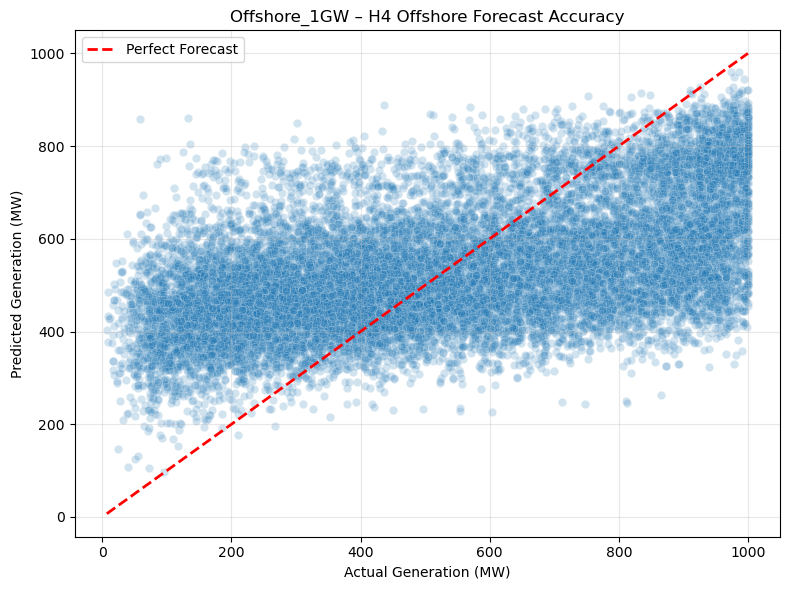

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# Load model bundle
power_b = joblib.load('models/full_balancing_bundle.pkl')

# Choose scenario + horizon
scenario = "Offshore_1GW" 
H = 4                 

bundle = power_b[scenario][H]
df_plot = datasets[scenario][H].copy()

# -----------------------------
# Feature Alignment
# -----------------------------
X_num = df_plot[bundle["num_cols"]].values

if len(bundle["cat_cols"]) > 0:
    X_cat = bundle["encoder"].transform(df_plot[bundle["cat_cols"]])
    X_enc = np.hstack([X_num, X_cat])
else:
    X_enc = X_num

y_actual = df_plot[f"Offshore_MW_t+{H}h"].values
y_pred = bundle["model"].predict(X_enc)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_actual, y=y_pred, alpha=0.2)
plt.plot(
    [y_actual.min(), y_actual.max()],
    [y_actual.min(), y_actual.max()],
    'r--',
    lw=2,
    label="Perfect Forecast"
)

plt.title(f"{scenario} – H{H} Offshore Forecast Accuracy")
plt.xlabel("Actual Generation (MW)")
plt.ylabel("Predicted Generation (MW)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


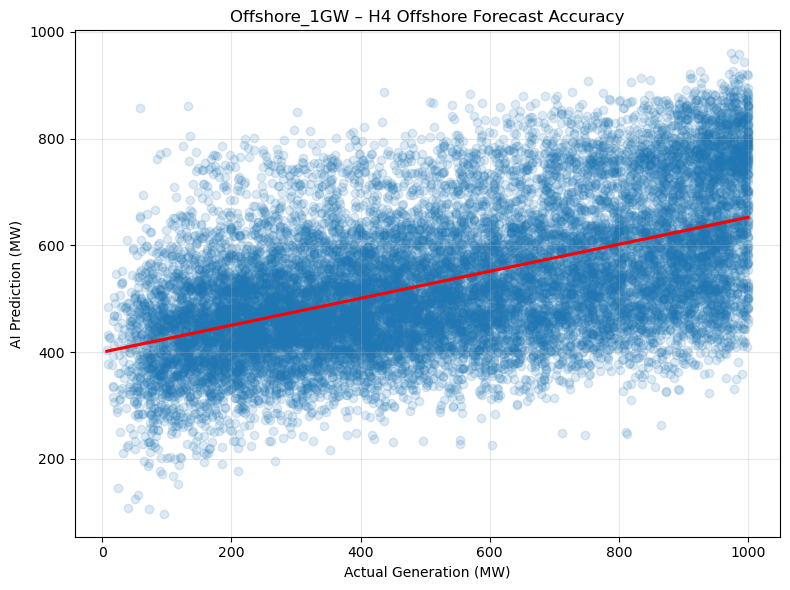

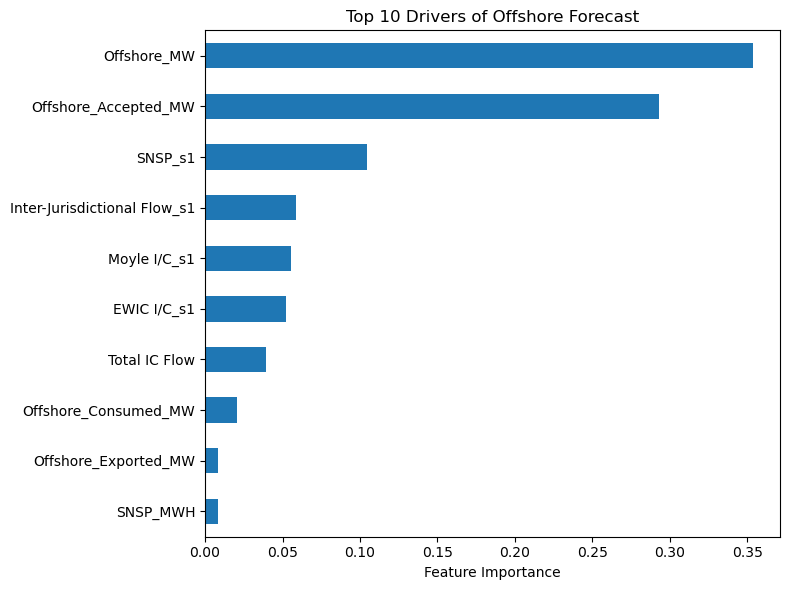

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

# =============================
# LOAD MODEL BUNDLE
# =============================
power_b = joblib.load('models/full_balancing_bundle.pkl')

scenario = "Offshore_1GW"  
H = 4               
mw_bundle = power_b[scenario][H]
df_final = datasets[scenario][H].copy()

# =============================
# SAFE PREDICT
# =============================
def safe_predict(df, bundle):
    required_num = bundle["num_cols"]
    required_cat = bundle["cat_cols"]

    X_num = df[required_num].values

    if len(required_cat) > 0:
        X_cat = bundle["encoder"].transform(df[required_cat])
        X_enc = np.hstack([X_num, X_cat])
    else:
        X_enc = X_num

    y_pred = bundle["model"].predict(X_enc)
    return y_pred

# =============================
# PLOT 1 — ACCURACY
# =============================
y_pred_mw = safe_predict(df_final, mw_bundle)
y_actual_mw = df_final[f"Offshore_MW_t+{H}h"].values

plt.figure(figsize=(8, 6))
sns.regplot(
    x=y_actual_mw,
    y=y_pred_mw,
    scatter_kws={'alpha':0.15},
    line_kws={'color':'red'}
)

plt.title(f"{scenario} – H{H} Offshore Forecast Accuracy")
plt.xlabel("Actual Generation (MW)")
plt.ylabel("AI Prediction (MW)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =============================
# PLOT 2 — FEATURE IMPORTANCE
# =============================
model = mw_bundle["model"]
encoder = mw_bundle["encoder"]

num_cols = mw_bundle["num_cols"]
cat_cols = mw_bundle["cat_cols"]

if len(cat_cols) > 0 and hasattr(encoder, "get_feature_names_out"):
    cat_names = encoder.get_feature_names_out(cat_cols).tolist()
    feature_names = num_cols + cat_names
else:
    feature_names = num_cols

importances = model.feature_importances_

# Ensure alignment
feature_names = feature_names[:len(importances)]

feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
feat_imp.sort_values().plot(kind="barh")
plt.title("Top 10 Drivers of Offshore Forecast")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


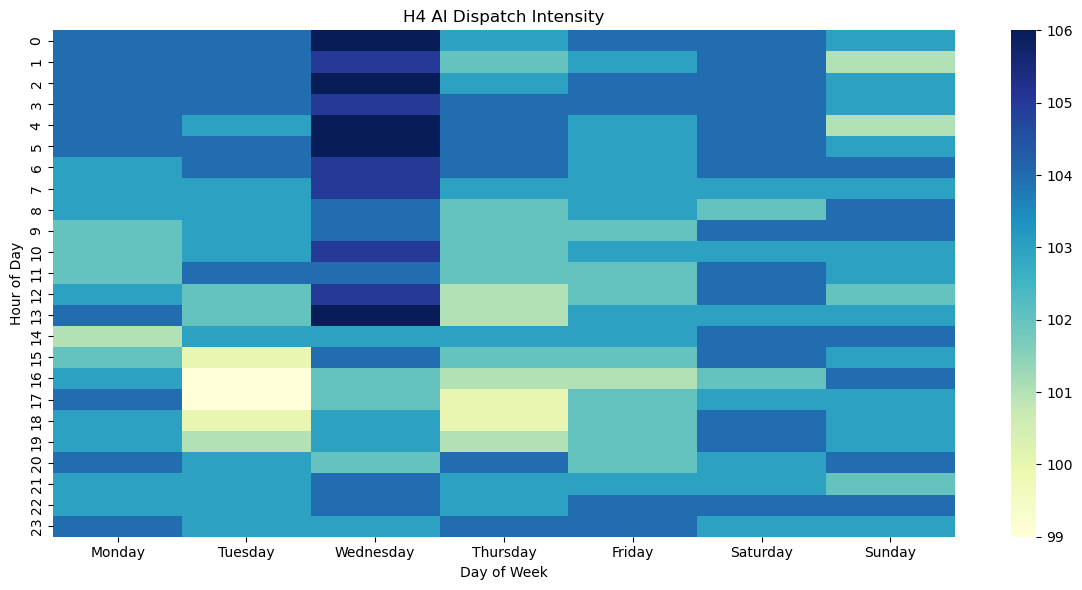

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

scenario = "Offshore_1GW"
H = 4

plot_df = datasets[scenario][H].copy()

plot_df["action"] = (plot_df[f"Sim_Export_H{H}"] > 0).astype(int)

plot_df = plot_df.copy()
plot_df.index = pd.to_datetime(plot_df.index)

# Create time features
plot_df["Hour"] = plot_df.index.hour
plot_df["Day"] = plot_df.index.day_name()

# Pivot table
dispatch_map = plot_df.pivot_table(
    index="Hour",
    columns="Day",
    values="action",
    aggfunc="sum",
    fill_value=0
)

# Reorder days
days_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]
dispatch_map = dispatch_map.reindex(columns=days_order)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(dispatch_map, cmap="YlGnBu")
plt.title(f"H{H} AI Dispatch Intensity")
plt.ylabel("Hour of Day")
plt.xlabel("Day of Week")
plt.tight_layout()
plt.show()


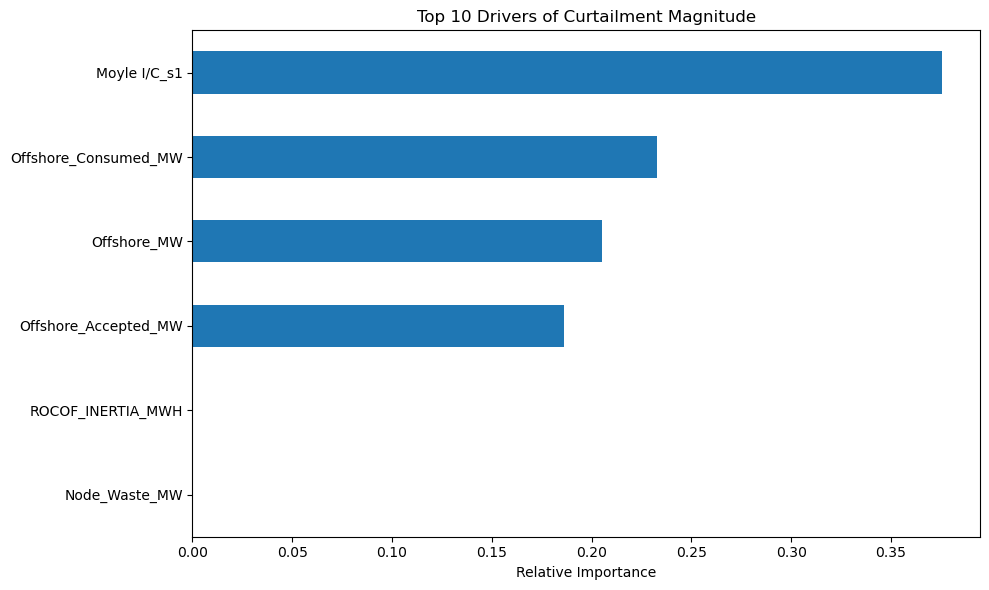

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import joblib

# Load magnitude bundle
mag_b = joblib.load('models/curtailment_magnitude_bundle.pkl')

scenario = "Offshore_1GW"
H = 4                     

bundle = mag_b[scenario][H]

model = bundle["model"]
feature_names = bundle["features"]

importances = model.feature_importances_

# Align safely
feature_names = feature_names[:len(importances)]

feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_imp.tail(10).plot(kind="barh")
plt.title("Top 10 Drivers of Curtailment Magnitude")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


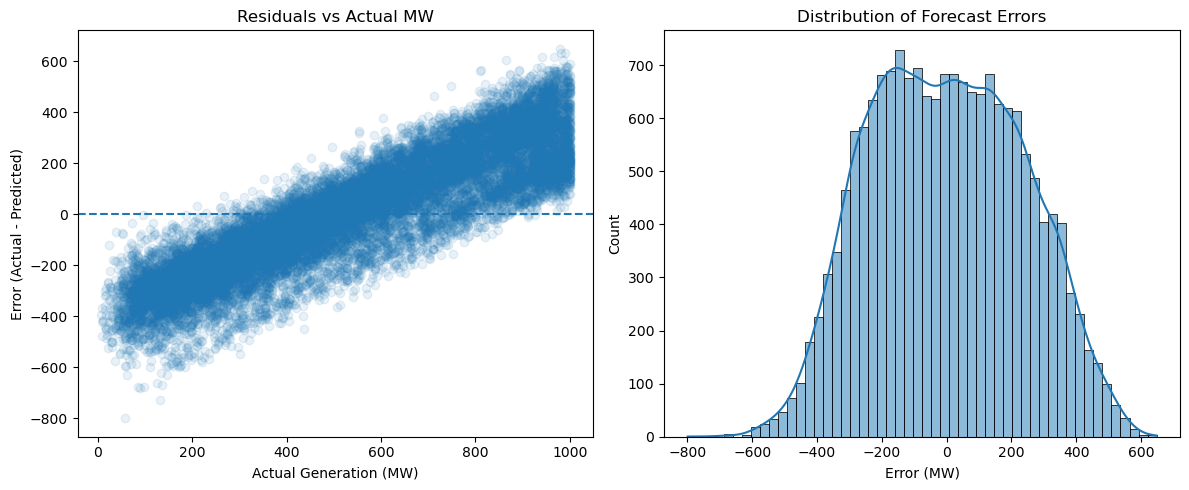

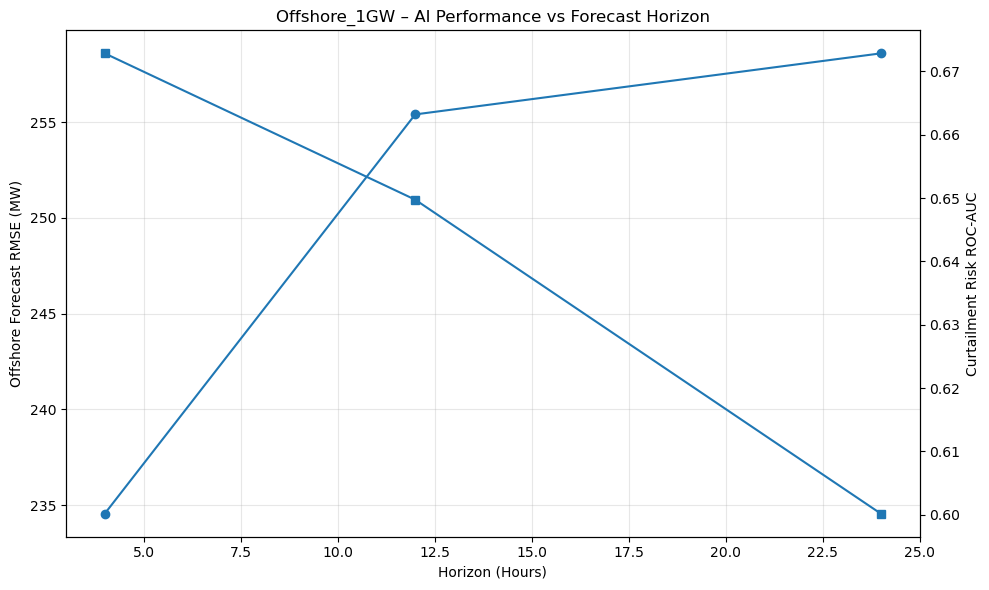

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import numpy as np

# =============================
# LOAD BUNDLES
# =============================
power_b = joblib.load('models/full_balancing_bundle.pkl')
risk_b  = joblib.load('models/curtailment_risk_bundle.pkl')

scenario = "Offshore_1GW"
H = 4

# =============================
# RECOMPUTE PREDICTIONS (if needed)
# =============================
bundle = power_b[scenario][H]
df_plot = datasets[scenario][H].copy()

X_num = df_plot[bundle["num_cols"]].values
if len(bundle["cat_cols"]) > 0:
    X_cat = bundle["encoder"].transform(df_plot[bundle["cat_cols"]])
    X_enc = np.hstack([X_num, X_cat])
else:
    X_enc = X_num

y_actual_mw = df_plot[f"Offshore_MW_t+{H}h"].values
y_pred_mw = bundle["model"].predict(X_enc)

# =============================
# RESIDUAL PLOTS
# =============================
residuals = y_actual_mw - y_pred_mw

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_actual_mw, residuals, alpha=0.1)
plt.axhline(0, linestyle='--')
plt.title("Residuals vs Actual MW")
plt.xlabel("Actual Generation (MW)")
plt.ylabel("Error (Actual - Predicted)")

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title("Distribution of Forecast Errors")
plt.xlabel("Error (MW)")

plt.tight_layout()
plt.show()


# =============================
# PERFORMANCE DECAY PLOT
# =============================

horizons = sorted(power_b[scenario].keys())

rmse_vals = []
roc_vals = []

for h in horizons:
    # RMSE recompute
    bundle = power_b[scenario][h]
    df_temp = datasets[scenario][h]

    X_num = df_temp[bundle["num_cols"]].values
    if len(bundle["cat_cols"]) > 0:
        X_cat = bundle["encoder"].transform(df_temp[bundle["cat_cols"]])
        X_enc = np.hstack([X_num, X_cat])
    else:
        X_enc = X_num

    y_true = df_temp[f"Offshore_MW_t+{h}h"].values
    y_pred = bundle["model"].predict(X_enc)

    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    rmse_vals.append(rmse)

    # ROC-AUC from risk model
    risk_bundle = risk_b[scenario][h]
    y_event = (df_temp[f"CURTAILMENTS_MWH_t+{h}h"] > 0).astype(int)
    y_prob = risk_bundle["model"].predict_proba(df_temp[risk_bundle["features"]])[:,1]

    from sklearn.metrics import roc_auc_score
    roc = roc_auc_score(y_event, y_prob)
    roc_vals.append(roc)


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Horizon (Hours)")
ax1.set_ylabel("Offshore Forecast RMSE (MW)")
ax1.plot(horizons, rmse_vals, marker='o')
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel("Curtailment Risk ROC-AUC")
ax2.plot(horizons, roc_vals, marker='s')

plt.title(f"{scenario} – AI Performance vs Forecast Horizon")
plt.tight_layout()
plt.show()


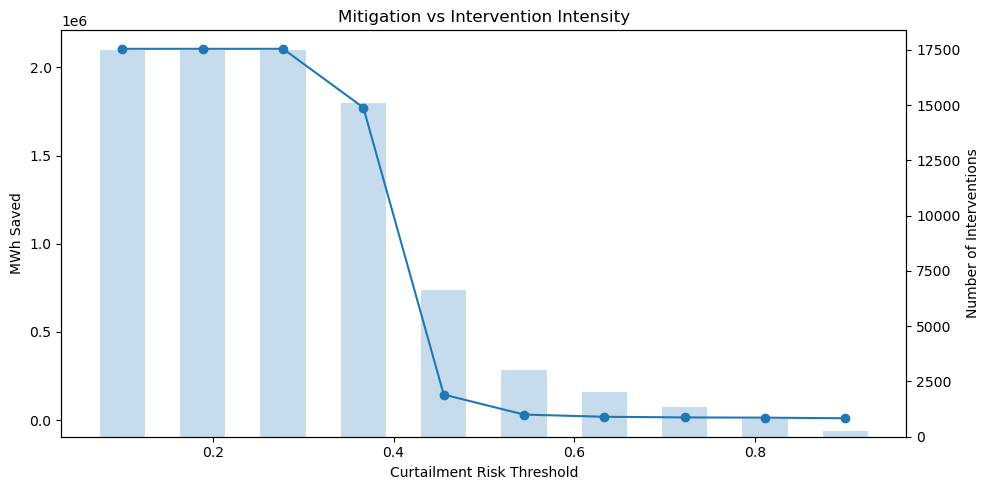

In [42]:
import numpy as np
import joblib

scenario = "Offshore_1GW"
H = 4

power_b = joblib.load('models/full_balancing_bundle.pkl')
risk_b  = joblib.load('models/curtailment_risk_bundle.pkl')
flow_b  = joblib.load('models/ic_flow_bundle.pkl')

df = datasets[scenario][H].copy()
n = len(df)

# --- Forecast offshore ---
bundle = power_b[scenario][H]
X_num = df[bundle["num_cols"]].values
if len(bundle["cat_cols"]) > 0:
    X_cat = bundle["encoder"].transform(df[bundle["cat_cols"]])
    X_enc = np.hstack([X_num, X_cat])
else:
    X_enc = X_num

offshore_pred = bundle["model"].predict(X_enc)

# --- Curtailment risk ---
risk_bundle = risk_b[scenario][H]
curt_risk_prob = risk_bundle["model"].predict_proba(
    df[risk_bundle["features"]]
)[:, 1]

# --- IC flow forecast ---
if H in flow_b[scenario]:
    flow_bundle = flow_b[scenario][H]
    ic_risk_prob = np.zeros(n)  # optional if no IC risk model used
    flow_pred = flow_bundle["model"].predict(df[flow_bundle["features"]])
else:
    flow_pred = np.zeros(n)
    ic_risk_prob = np.zeros(n)

# --- Demand ---
demand_col = [c for c in df.columns if "demand" in c.lower()]
demand = df[demand_col[0]].values if demand_col else np.ones(n)

IC_CAPACITY_MAX = 1000
AMBIENT_DERATING = 0.97
dynamic_cap = IC_CAPACITY_MAX * AMBIENT_DERATING

# --- Physical baseline curtailment ---
surplus = offshore_pred - demand
headroom = dynamic_cap - np.abs(flow_pred)
baseline_curt = np.maximum(surplus - headroom, 0)

total_baseline = np.sum(baseline_curt)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# SENSITIVITY ANALYSIS + PLOT
# =============================

TAU_IC_RISK = 0.8
DISPATCH_EFF = 0.92

thresholds = np.linspace(0.1, 0.9, 10)
results_sensitivity = []

for tau in thresholds:

    actions = (curt_risk_prob > tau) & (ic_risk_prob < TAU_IC_RISK)

    temp_curt = baseline_curt.copy()

    reduction = temp_curt[actions] * DISPATCH_EFF
    temp_curt[actions] = np.maximum(temp_curt[actions] - reduction, 0)

    saved = total_baseline - np.sum(temp_curt)

    results_sensitivity.append({
        "threshold": tau,
        "saved_mwh": saved,
        "actions": int(actions.sum())
    })

sens_df = pd.DataFrame(results_sensitivity)

# =============================
# PLOT
# =============================

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(
    sens_df["threshold"],
    sens_df["saved_mwh"],
    marker="o"
)
ax1.set_xlabel("Curtailment Risk Threshold")
ax1.set_ylabel("MWh Saved")

ax2 = ax1.twinx()
ax2.bar(
    sens_df["threshold"],
    sens_df["actions"],
    alpha=0.25,
    width=0.05
)
ax2.set_ylabel("Number of Interventions")

plt.title("Mitigation vs Intervention Intensity")
plt.tight_layout()
plt.show()


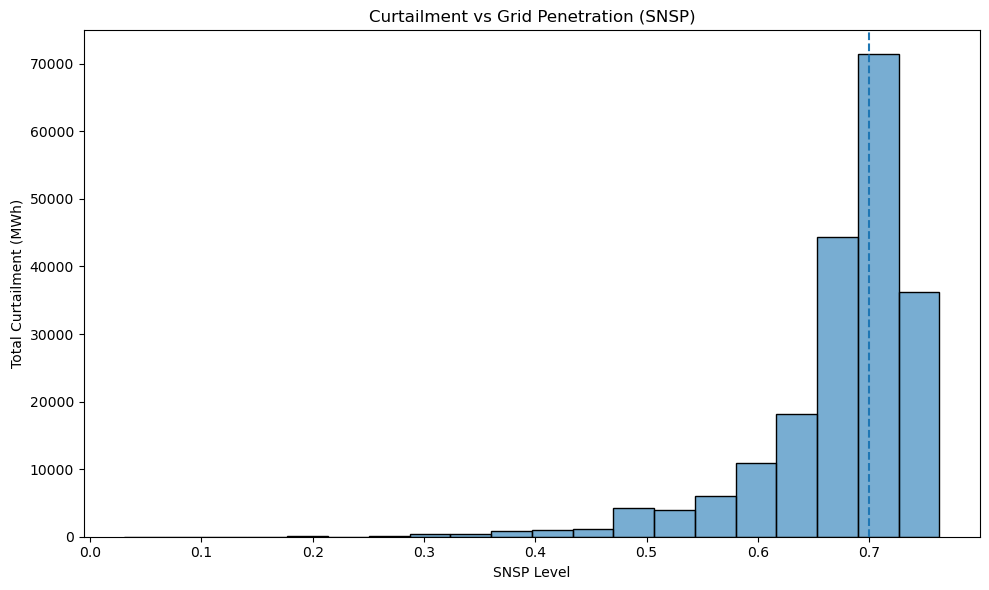

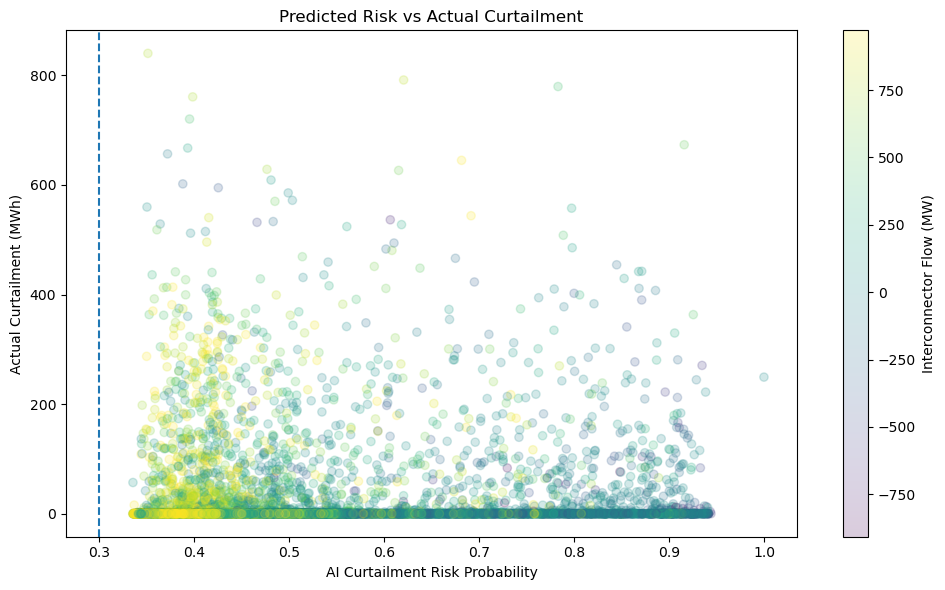

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

scenario = "Offshore_1GW"
H = 4

df_sim = datasets[scenario][H].copy()
df_sim.index = pd.to_datetime(df_sim.index)

# Define target column
target_col = f"CURTAILMENTS_MWH_t+{H}h"

# =============================
# 1. Curtailment vs SNSP
# =============================
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_sim,
    x="SNSP_s1",
    weights=df_sim[target_col],
    bins=20,
    alpha=0.6
)

plt.axvline(x=0.70, linestyle="--")
plt.title("Curtailment vs Grid Penetration (SNSP)")
plt.xlabel("SNSP Level")
plt.ylabel("Total Curtailment (MWh)")
plt.tight_layout()
plt.show()


# =============================
# 2. Risk vs Actual Curtailment
# =============================
plt.figure(figsize=(10, 6))

plt.scatter(
    curt_risk_prob,
    df_sim[target_col].values,
    alpha=0.2,
    c=df_sim["Total IC Flow_t+{}h".format(H)] if f"Total IC Flow_t+{H}h" in df_sim.columns else "blue"
)

plt.colorbar(label="Interconnector Flow (MW)")
plt.axvline(x=0.3, linestyle="--")
plt.title("Predicted Risk vs Actual Curtailment")
plt.xlabel("AI Curtailment Risk Probability")
plt.ylabel("Actual Curtailment (MWh)")
plt.tight_layout()
plt.show()

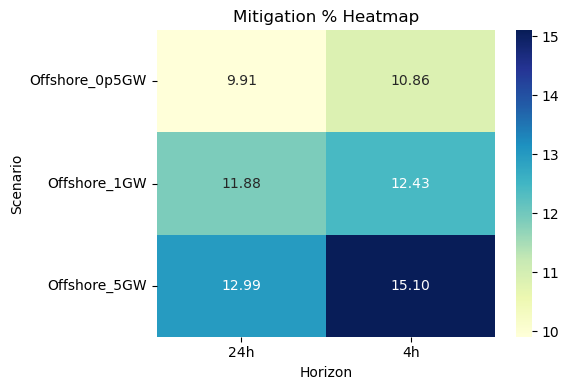

In [53]:
pivot_df = results_df.pivot(
    index="Scenario",
    columns="Horizon",
    values="Net Mitigation (%)"
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Mitigation % Heatmap")
plt.tight_layout()
plt.show()


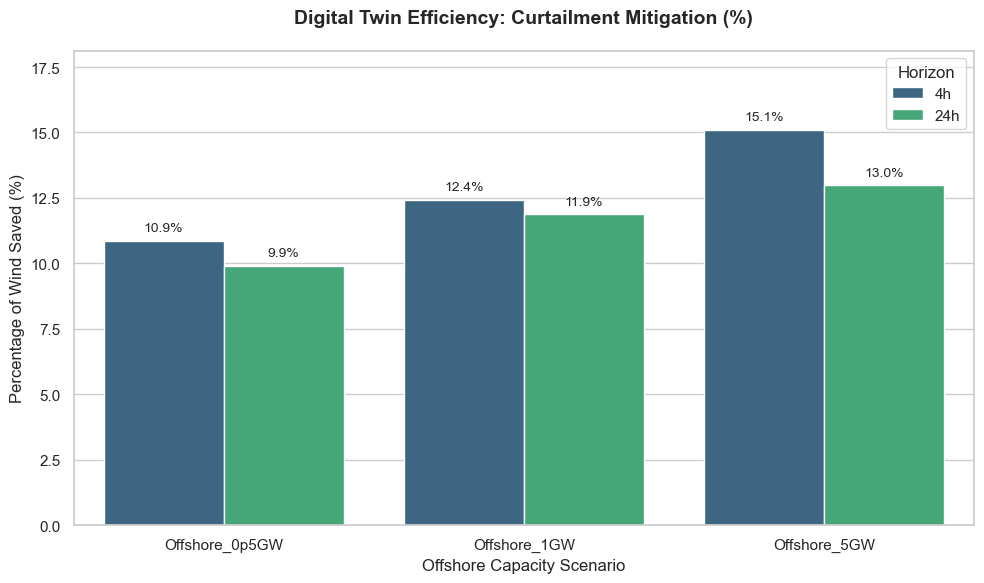

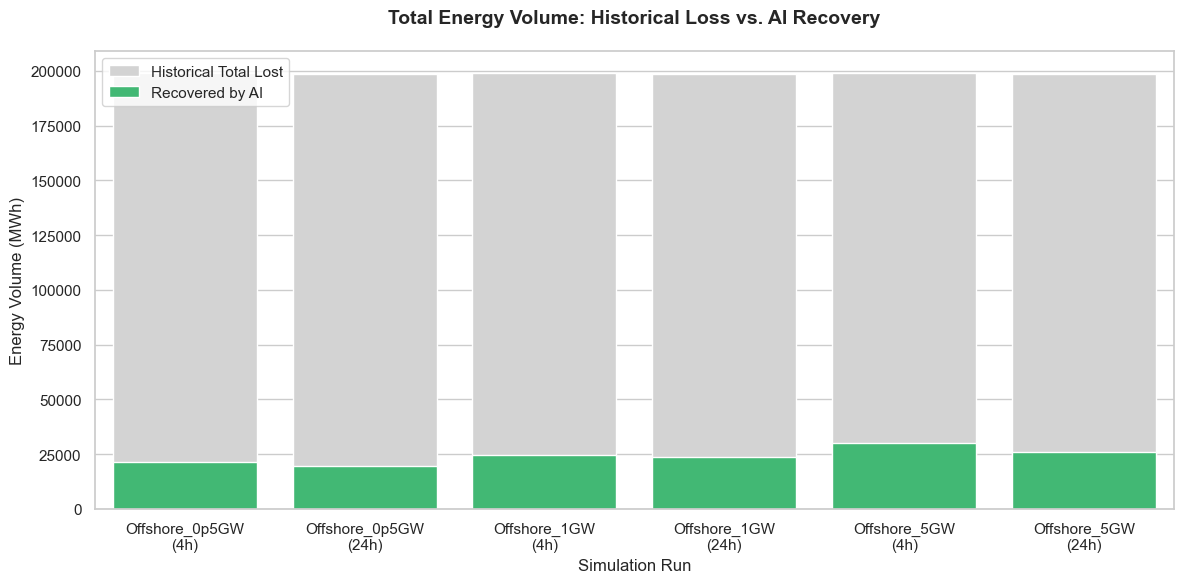

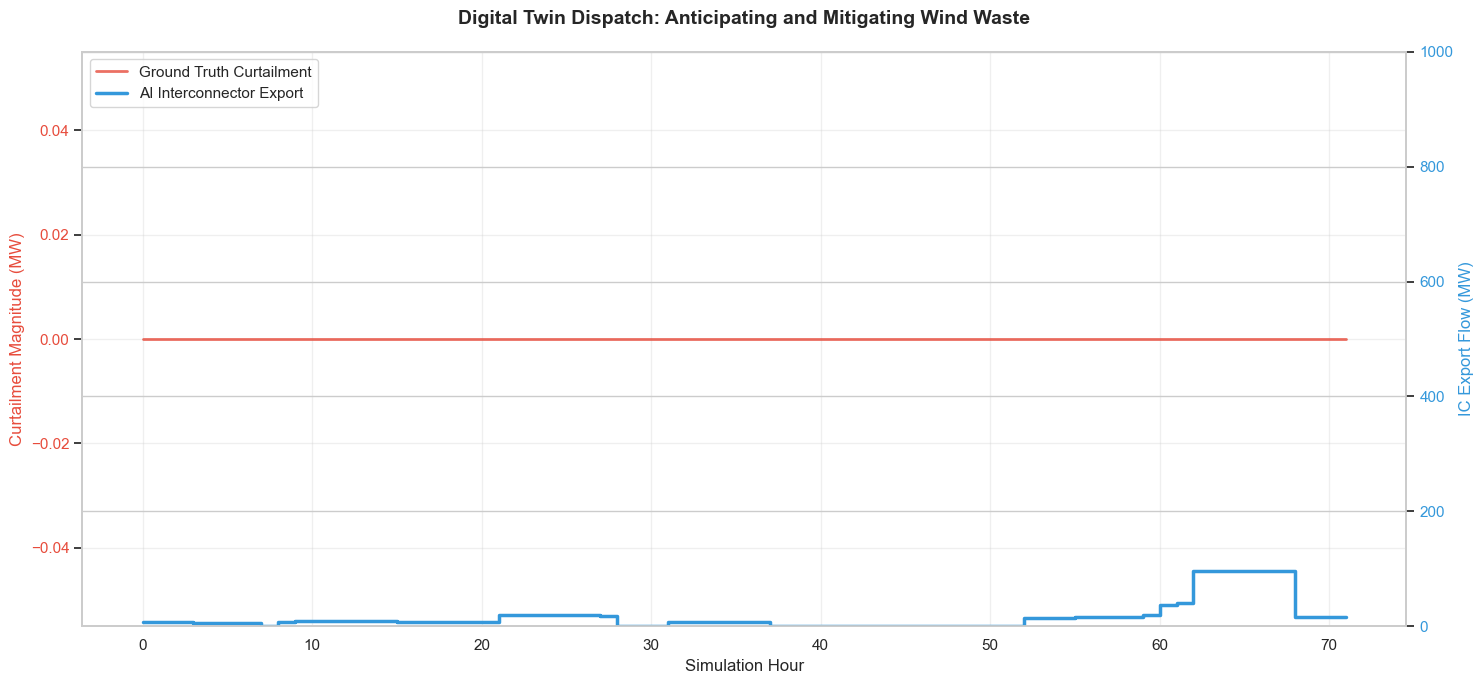

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df_plot = pd.DataFrame(twin_results)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# =================================================================
# PLOT 1: MITIGATION EFFICIENCY (%)
# Shows how well the AI handles each scenario and horizon
# =================================================================
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=df_plot, x='Scenario', y='Net Mitigation (%)', hue='Horizon', palette='viridis')
plt.title('Digital Twin Efficiency: Curtailment Mitigation (%)', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Percentage of Wind Saved (%)', fontsize=12)
plt.xlabel('Offshore Capacity Scenario', fontsize=12)
plt.ylim(0, df_plot['Net Mitigation (%)'].max() * 1.2)

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

# =================================================================
# PLOT 2: ENERGY VOLUME (LOST VS. SAVED)
# Highlights the raw MWh recovered by the AI
# =================================================================
# Create a unique label for Scenario + Horizon
df_plot['Run'] = df_plot['Scenario'] + "\n(" + df_plot['Horizon'] + ")"

plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x='Run', y='Actual Wind Lost (MWh)', color='lightgrey', label='Historical Total Lost')
sns.barplot(data=df_plot, x='Run', y='Wind Saved by AI (MWh)', color='#2ecc71', label='Recovered by AI')

plt.title('Total Energy Volume: Historical Loss vs. AI Recovery', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Energy Volume (MWh)', fontsize=12)
plt.xlabel('Simulation Run', fontsize=12)
plt.legend(frameon=True, loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# =================================================================
# PLOT 3: THE "IN-ACTION" TIME SERIES
# This plots a specific window of time to show the MPC logic working
# Note: Requires the 'real_curtailment' and 'ic_usage_log' from your loop
# =================================================================
t_range = range(min(72, len(real_curtailment)))

fig, ax_main = plt.subplots(figsize=(15, 7))

# Plot Curtailment (The Problem)
ax_main.plot(t_range, real_curtailment[:72], color='#e74c3c', label='Ground Truth Curtailment', linewidth=2, alpha=0.8)
ax_main.fill_between(t_range, real_curtailment[:72], color='#e74c3c', alpha=0.1)
ax_main.set_ylabel('Curtailment Magnitude (MW)', color='#e74c3c', fontsize=12)
ax_main.tick_params(axis='y', labelcolor='#e74c3c')

# Create second axis for Interconnector (The Solution)
ax_twin = ax_main.twinx()
ax_twin.step(t_range, ic_usage_log[:72], color='#3498db', where='post', label='AI Interconnector Export', linewidth=2.5)
ax_twin.set_ylabel('IC Export Flow (MW)', color='#3498db', fontsize=12)
ax_twin.tick_params(axis='y', labelcolor='#3498db')
ax_twin.set_ylim(0, 1000) # IC Capacity

plt.title('Digital Twin Dispatch: Anticipating and Mitigating Wind Waste', fontsize=14, fontweight='bold', pad=20)
ax_main.set_xlabel('Simulation Hour', fontsize=12)
ax_main.grid(True, alpha=0.3)

# Combine legends
lines_1, labels_1 = ax_main.get_legend_handles_labels()
lines_2, labels_2 = ax_twin.get_legend_handles_labels()
ax_main.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()


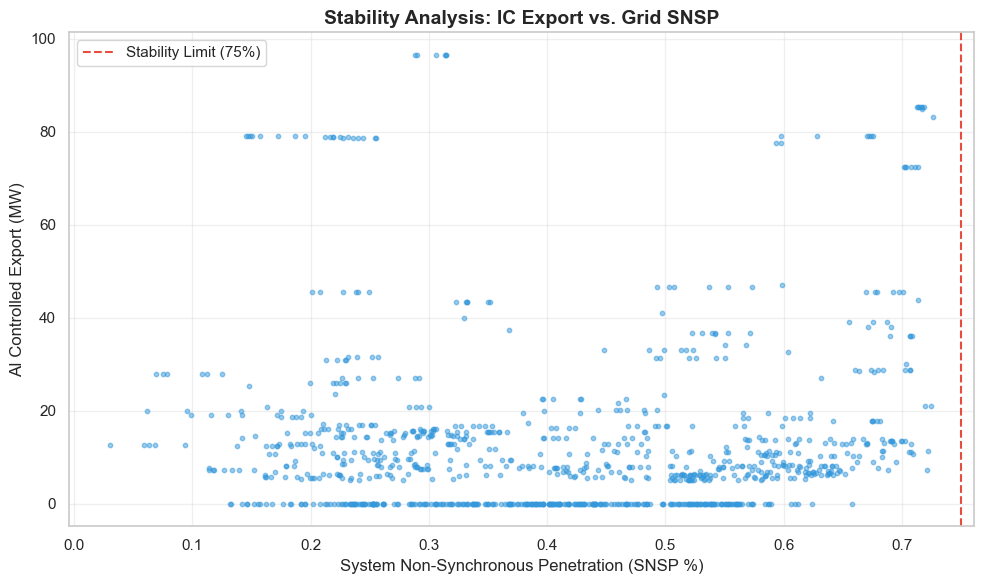

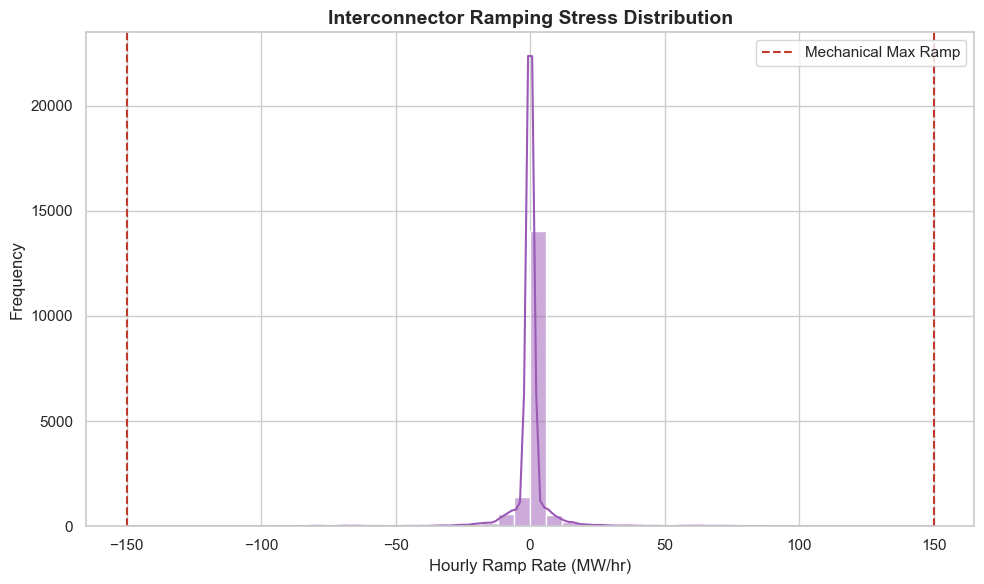

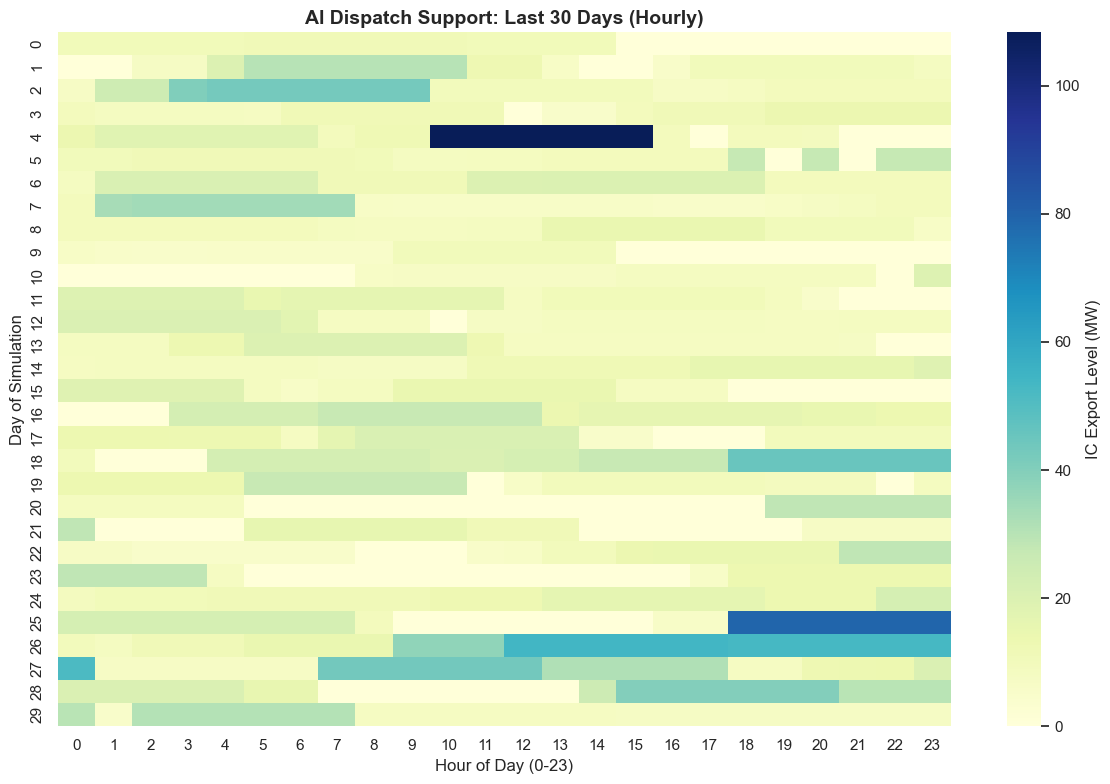

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =================================================================
# PLOT 4: THE STABILITY GATE (SNSP ANALYSIS)
# Proves the AI respects the 75% stability limit
# =================================================================
plt.figure(figsize=(10, 6))
plt.scatter(real_snsp[:1000], ic_usage_log[:1000], alpha=0.5, c='#3498db', s=10)
plt.axvline(x=SNSP_LIMIT, color='#e74c3c', linestyle='--', label='Stability Limit (75%)')

plt.title('Stability Analysis: IC Export vs. Grid SNSP', fontsize=14, fontweight='bold')
plt.xlabel('System Non-Synchronous Penetration (SNSP %)', fontsize=12)
plt.ylabel('AI Controlled Export (MW)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =================================================================
# PLOT 5: RAMPING INTENSITY (MACHINE STRESS)
# Proves the AI stays within the 150MW/hr mechanical limit
# =================================================================
ramps = np.diff(ic_usage_log)

plt.figure(figsize=(10, 6))
sns.histplot(ramps, bins=50, kde=True, color='#9b59b6')
plt.axvline(x=RAMP_LIMIT_MW, color='#c0392b', linestyle='--', label='Mechanical Max Ramp')
plt.axvline(x=-RAMP_LIMIT_MW, color='#c0392b', linestyle='--')

plt.title('Interconnector Ramping Stress Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Hourly Ramp Rate (MW/hr)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# =================================================================
# PLOT 6: DIURNAL MITIGATION HEATMAP
# Shows exactly what hours of the day the AI is most useful
# =================================================================
days_to_plot = 30
heatmap_raw = np.array(ic_usage_log[-(days_to_plot*24):]).reshape(days_to_plot, 24)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_raw, cmap='YlGnBu', cbar_kws={'label': 'IC Export Level (MW)'})

plt.title(f'AI Dispatch Support: Last {days_to_plot} Days (Hourly)', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Day of Simulation', fontsize=12)
plt.tight_layout()
plt.show()

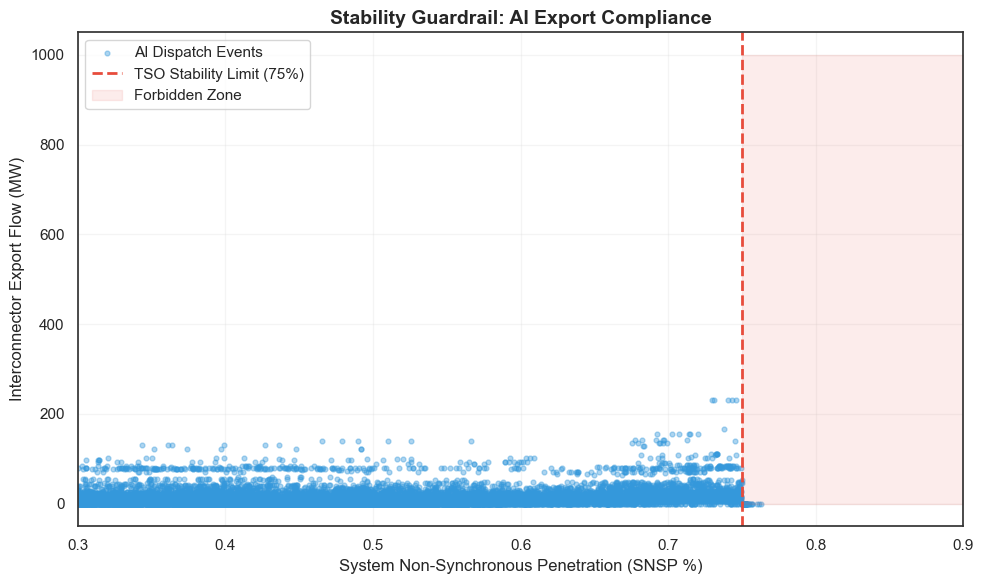

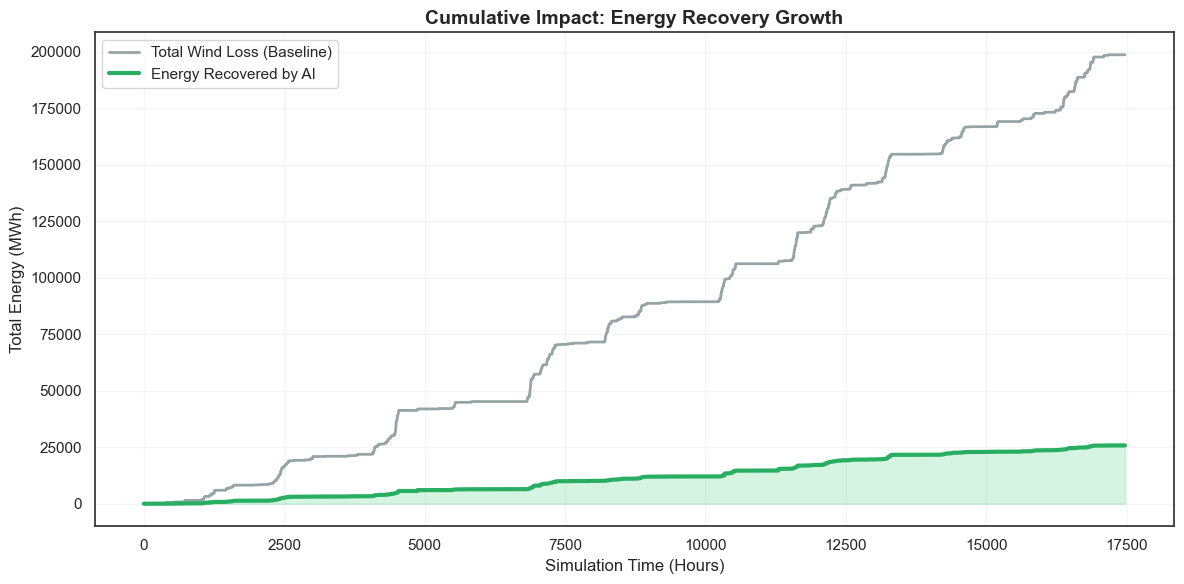

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme(style="white", palette="muted")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor'] = '#333333'

# =================================================================
# 1. THE STABILITY GATE (SNSP VS. EXPORT)
# Proves the AI respects the 75% System Stability Limit
# =================================================================
plt.figure(figsize=(10, 6))
plt.scatter(real_snsp, ic_usage_log, alpha=0.4, c='#3498db', s=12, label='AI Dispatch Events')
plt.axvline(x=SNSP_LIMIT, color='#e74c3c', linestyle='--', linewidth=2, label='TSO Stability Limit (75%)')
plt.fill_betweenx([0, 1000], SNSP_LIMIT, 1.0, color='#e74c3c', alpha=0.1, label='Forbidden Zone')

plt.title('Stability Guardrail: AI Export Compliance', fontsize=14, fontweight='bold')
plt.xlabel('System Non-Synchronous Penetration (SNSP %)', fontsize=12)
plt.ylabel('Interconnector Export Flow (MW)', fontsize=12)
plt.xlim(0.3, 0.9) # Focus on the high-renewable range
plt.legend(loc='upper left', frameon=True)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# =================================================================
# 4. CUMULATIVE MITIGATION (THE SUCCESS STORY)
# Tracks the total "Saved Wind" over the entire year
# =================================================================
cum_lost = np.cumsum(real_curtailment)
cum_saved = np.cumsum(saved_energy_mwh)

plt.figure(figsize=(12, 6))
plt.plot(cum_lost, color='#95a5a6', label='Total Wind Loss (Baseline)', linewidth=2)
plt.plot(cum_saved, color='#27ae60', label='Energy Recovered by AI', linewidth=3)
plt.fill_between(range(len(cum_saved)), cum_saved, color='#2ecc71', alpha=0.2)

plt.title('Cumulative Impact: Energy Recovery Growth', fontsize=14, fontweight='bold')
plt.ylabel('Total Energy (MWh)', fontsize=12)
plt.xlabel('Simulation Time (Hours)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

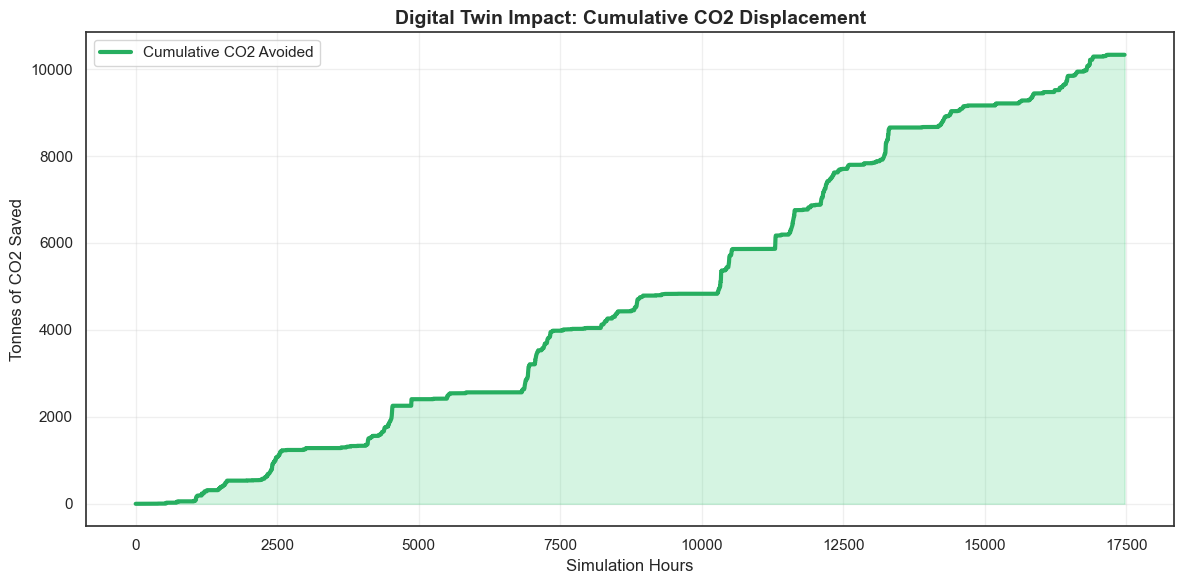

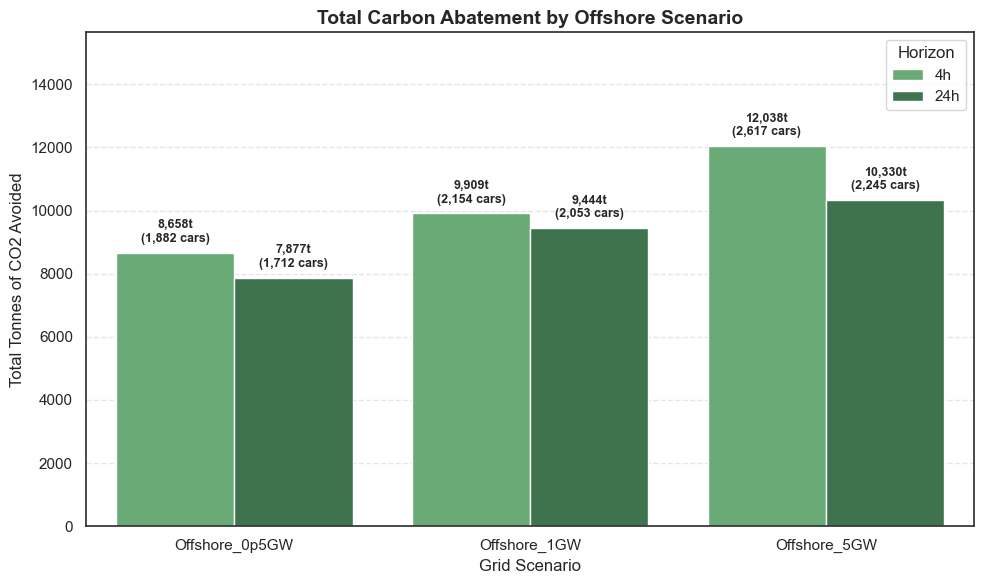

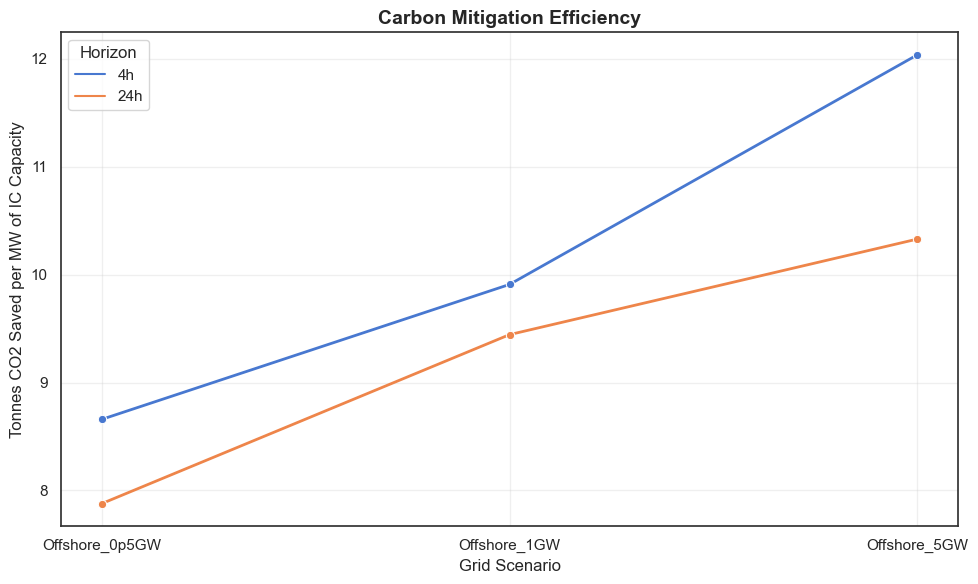

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Configuration: Carbon Intensity Factor
# (0.4 tonnes CO2 / MWh is standard for displacing Natural Gas/CCGT)
CO2_FACTOR = 0.4 

# 2. Add Carbon Data to your results
for result in twin_results:
    mwh_saved = result["Wind Saved by AI (MWh)"]
    result["CO2 Displacement (Tonnes)"] = mwh_saved * CO2_FACTOR

df_carbon = pd.DataFrame(twin_results)

# =================================================================
# PLOT 7: CUMULATIVE CARBON SAVINGS (The Environmental Story)
# =================================================================
cum_co2_saved = np.cumsum(saved_energy_mwh) * CO2_FACTOR

plt.figure(figsize=(12, 6))
plt.plot(cum_co2_saved, color='#27ae60', linewidth=3, label='Cumulative CO2 Avoided')
plt.fill_between(range(len(cum_co2_saved)), cum_co2_saved, color='#2ecc71', alpha=0.2)

plt.title('Digital Twin Impact: Cumulative CO2 Displacement', fontsize=14, fontweight='bold')
plt.ylabel('Tonnes of CO2 Saved', fontsize=12)
plt.xlabel('Simulation Hours', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =================================================================
# PLOT 8: CARBON ABATEMENT BY SCENARIO
# =================================================================
plt.figure(figsize=(10, 6))
sns.barplot(data=df_carbon, x='Scenario', y='CO2 Displacement (Tonnes)', hue='Horizon', palette='Greens_d')

plt.title('Total Carbon Abatement by Offshore Scenario', fontsize=14, fontweight='bold')
plt.ylabel('Total Tonnes of CO2 Avoided', fontsize=12)
plt.xlabel('Grid Scenario', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for p in plt.gca().patches:
    tonnes = p.get_height()
    if tonnes > 0:
        cars = int(tonnes / 4.6)
        plt.gca().annotate(f'{tonnes:,.0f}t\n({cars:,} cars)', 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 15), 
                           textcoords='offset points', fontsize=9, fontweight='bold')

plt.ylim(0, df_carbon['CO2 Displacement (Tonnes)'].max() * 1.3)
plt.tight_layout()
plt.show()

# =================================================================
# PLOT 9: CARBON EFFICIENCY (Tonnes Saved per MW of IC Capacity)
# =================================================================
df_carbon['CO2_Efficiency'] = df_carbon['CO2 Displacement (Tonnes)'] / 1000 # per MW IC

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_carbon, x='Scenario', y='CO2_Efficiency', marker='o', hue='Horizon', linewidth=2)

plt.title('Carbon Mitigation Efficiency', fontsize=14, fontweight='bold')
plt.ylabel('Tonnes CO2 Saved per MW of IC Capacity', fontsize=12)
plt.xlabel('Grid Scenario', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()